# Random Walk: A Rent vs Buy Simulation for 2018
## Author: Connor Anderson

### Monte Carlo analysis based on Khan Academy Spreadsheet found [here](https://cdn.kastatic.org/downloads/buyrent.xls)

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from time import sleep

In [15]:
# --------------- Home Inputs ------------------ #
PURCHASE_PRICE = 750000
DOWNPAYMENT = PURCHASE_PRICE*0.2
INTEREST_RATE = 0.046
PRINCIPLE_AMORTIZATION = 30
PROPERTY_TAX = 0.008
ANNUAL_MAINTENENCE = 1000
HOA_ANNUAL = 0
INSURANCE_ANNUAL = 0.01*PURCHASE_PRICE
AVERAGE_APPRECIATION_ANNUAL = 0.03
MARGINAL_INCOME_TAX_RATE = 0.33
INFLATION = 0.02
MONTHLY_MORTGAGE_PAYMENT = (PURCHASE_PRICE-DOWNPAYMENT)*(1-1/(1+INTEREST_RATE/12))/(1-1/(1+INTEREST_RATE/12)**(PRINCIPLE_AMORTIZATION*12+1))
TRANSACTION_SALE_COST = 0.06

print("Mortgage Payment: " + str(MONTHLY_MORTGAGE_PAYMENT))
print("Starting Monthly Payment: " + str(MONTHLY_MORTGAGE_PAYMENT + INSURANCE_ANNUAL/12 + HOA_ANNUAL/12 + ANNUAL_MAINTENENCE/12 + PROPERTY_TAX*PURCHASE_PRICE/12))

Mortgage Payment: 3060.1783771510773
Starting Monthly Payment: 4268.51171048441


In [16]:
# ---------------Rental Inputs ------------------ #
EQUIVALENT_RENTAL_COST = 2500
RENTAL_PRICE_INFLATION_ANNUAL = 0.03
STOCK_MARKET_ANNUAL_RETURN = 0.06  # Post tax return

In [17]:
def get_monthly_projection(start_value, monthly_return, monthly_return_std, additions = np.array([])):
    if additions.size != PRINCIPLE_AMORTIZATION*12 and additions.size != 0:
        print("There was not an addition for every month!")
        return
    return_vec = [start_value]
    random_returns = np.random.normal(monthly_return, monthly_return_std, PRINCIPLE_AMORTIZATION*12)
    for i in range(PRINCIPLE_AMORTIZATION*12):
        if additions.size == 0:
            return_vec.append(return_vec[-1]*(1+random_returns[i]))
        else:
            return_vec.append(return_vec[-1]*(1+random_returns[i]) + additions[i])
    return return_vec

In [18]:
def run_simulation(home_appreciation_std=0, market_std=0, fixed_property_tax=False, PURCHASE_PRICE=PURCHASE_PRICE,DOWNPAYMENT=DOWNPAYMENT,MONTHLY_MORTGAGE_PAYMENT
=MONTHLY_MORTGAGE_PAYMENT ):
    home_value = []
    home_sale_value = []
    rent_value = []
    
    # Compute the home values, then the final sale values
    home_value = get_monthly_projection(PURCHASE_PRICE, AVERAGE_APPRECIATION_ANNUAL/12, home_appreciation_std)
    home_sale_cost = np.array(home_value) * TRANSACTION_SALE_COST
        
    # Compute monthly payments
    mortgage = get_monthly_projection(MONTHLY_MORTGAGE_PAYMENT, 0, 0)
    insurance = get_monthly_projection(INSURANCE_ANNUAL/12, INFLATION/12, 0)
    hoa = get_monthly_projection(HOA_ANNUAL/12, INFLATION/12, 0)
    maintenence = get_monthly_projection(ANNUAL_MAINTENENCE/12, INFLATION/12, 0)
    if fixed_property_tax:
        property_tax = get_monthly_projection(PURCHASE_PRICE*0.01/12, INFLATION/12, 0)
    else:
        property_tax = np.array(home_value)*PROPERTY_TAX/12
        
    # Figure out tax savings from interest payments
    debt = [PURCHASE_PRICE - DOWNPAYMENT]
    debt_interest = [INTEREST_RATE*debt[-1]/12]
    for i in range(PRINCIPLE_AMORTIZATION*12): 
        debt_principle = mortgage[i] - debt_interest[-1]
        debt.append(debt[-1] - debt_principle)
        debt_interest.append(INTEREST_RATE*debt[-1]/12)
        
    home_equity = np.array(home_value) - np.array(debt) - np.array(home_sale_cost)
    
        
    tax_savings = (np.array(debt_interest) + np.array(property_tax))*MARGINAL_INCOME_TAX_RATE        
    
    # Compute net monthly outlay
    
    total_cashflow = np.array(mortgage) + np.array(insurance) + np.array(hoa) + \
                         np.array(maintenence) + np.array(property_tax) - tax_savings
        
    # Compute the invested amount and the final return
    rent_cost = get_monthly_projection(EQUIVALENT_RENTAL_COST, RENTAL_PRICE_INFLATION_ANNUAL/12, 0)
    additions = np.array(total_cashflow) - np.array(rent_cost)
    rent_value = get_monthly_projection(DOWNPAYMENT, STOCK_MARKET_ANNUAL_RETURN/12, 
                                        market_std, additions=additions[:-1])
    
    # Return a list of the differences at every year mark
    cost_benefit_array = np.array(home_equity) - np.array(rent_value)
    cost_benefit_present_value = []
    for i in range(len(cost_benefit_array)):
        cost_benefit_present_value.append(cost_benefit_array[i]/(1+INFLATION)**(i/12))
    return cost_benefit_present_value, rent_value, home_equity, home_value, debt
    

# Baseline Comparison 

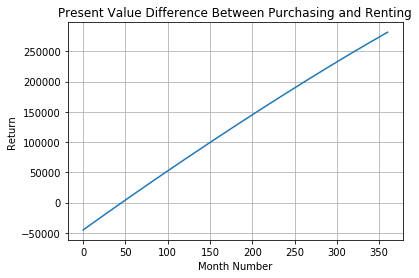

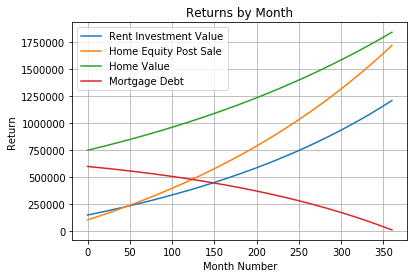

In [19]:
cost_diff, rent_value, home_sale_value, home_value, debt = run_simulation(fixed_property_tax=False)
# the histogram of the data
plt.plot(range(len(cost_diff)),cost_diff,label='gauss multiples')

plt.xlabel('Month Number')
plt.ylabel('Return')
plt.title('Present Value Difference Between Purchasing and Renting')
plt.grid(True)

plt.show() 
# the histogram of the data
plt.plot(range(len(rent_value)),rent_value,label='Rent Investment Value')
plt.plot(range(len(home_sale_value)),home_sale_value,label='Home Equity Post Sale')
plt.plot(range(len(home_value)),home_value,label='Home Value')
plt.plot(range(len(debt)),debt,label='Mortgage Debt')

plt.xlabel('Month Number')
plt.ylabel('Return')
plt.legend()
plt.title('Returns by Month')
plt.grid(True)

plt.show() 

# CA Specific Simulation with Fixed Property Tax @ 1% (Prop 13)

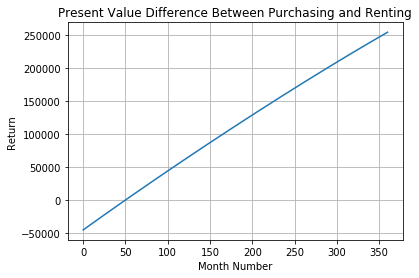

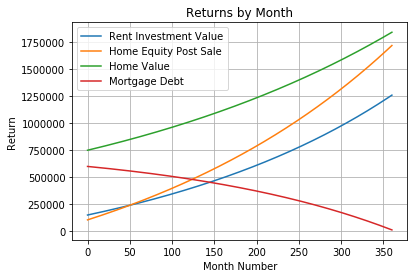

In [20]:
cost_diff, rent_value, home_sale_value, home_value, debt = run_simulation(fixed_property_tax=True)
# the histogram of the data
plt.plot(range(len(cost_diff)),cost_diff,label='gauss multiples')

plt.xlabel('Month Number')
plt.ylabel('Return')
plt.title('Present Value Difference Between Purchasing and Renting')
plt.grid(True)

plt.show() 
# the histogram of the data
plt.plot(range(len(rent_value)),rent_value,label='Rent Investment Value')
plt.plot(range(len(home_sale_value)),home_sale_value,label='Home Equity Post Sale')
plt.plot(range(len(home_value)),home_value,label='Home Value')
plt.plot(range(len(debt)),debt,label='Mortgage Debt')

plt.xlabel('Month Number')
plt.ylabel('Return')
plt.legend()
plt.title('Returns by Month')
plt.grid(True)

plt.show() 

# Simulation with Typical Variance in Home and Stock Markets

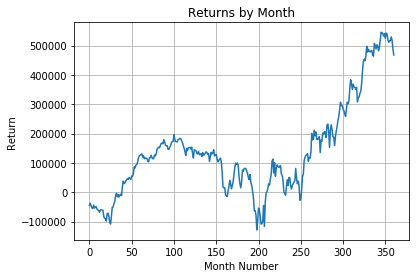

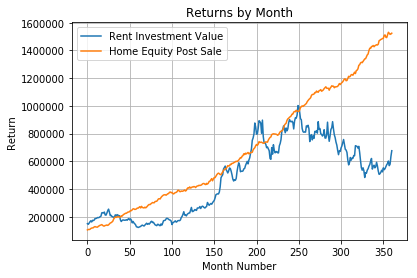

In [21]:
cost_diff, rent_value, home_sale_value, home_value, debt = run_simulation(home_appreciation_std=0.006, market_std=0.045, fixed_property_tax=True)
# the histogram of the data
plt.plot(range(len(cost_diff)),cost_diff,label='gauss multiples')

plt.xlabel('Month Number')
plt.ylabel('Return')
plt.title('Returns by Month')
plt.grid(True)

plt.show() 
# the histogram of the data
plt.plot(range(len(rent_value)),rent_value,label='Rent Investment Value')
plt.plot(range(len(home_sale_value)),home_sale_value,label='Home Equity Post Sale')

plt.xlabel('Month Number')
plt.ylabel('Return')
plt.legend()
plt.title('Returns by Month')
plt.grid(True)

plt.show() 

## Analysis at 10 Year Mark (Histogram of Most Likely Outcomes)

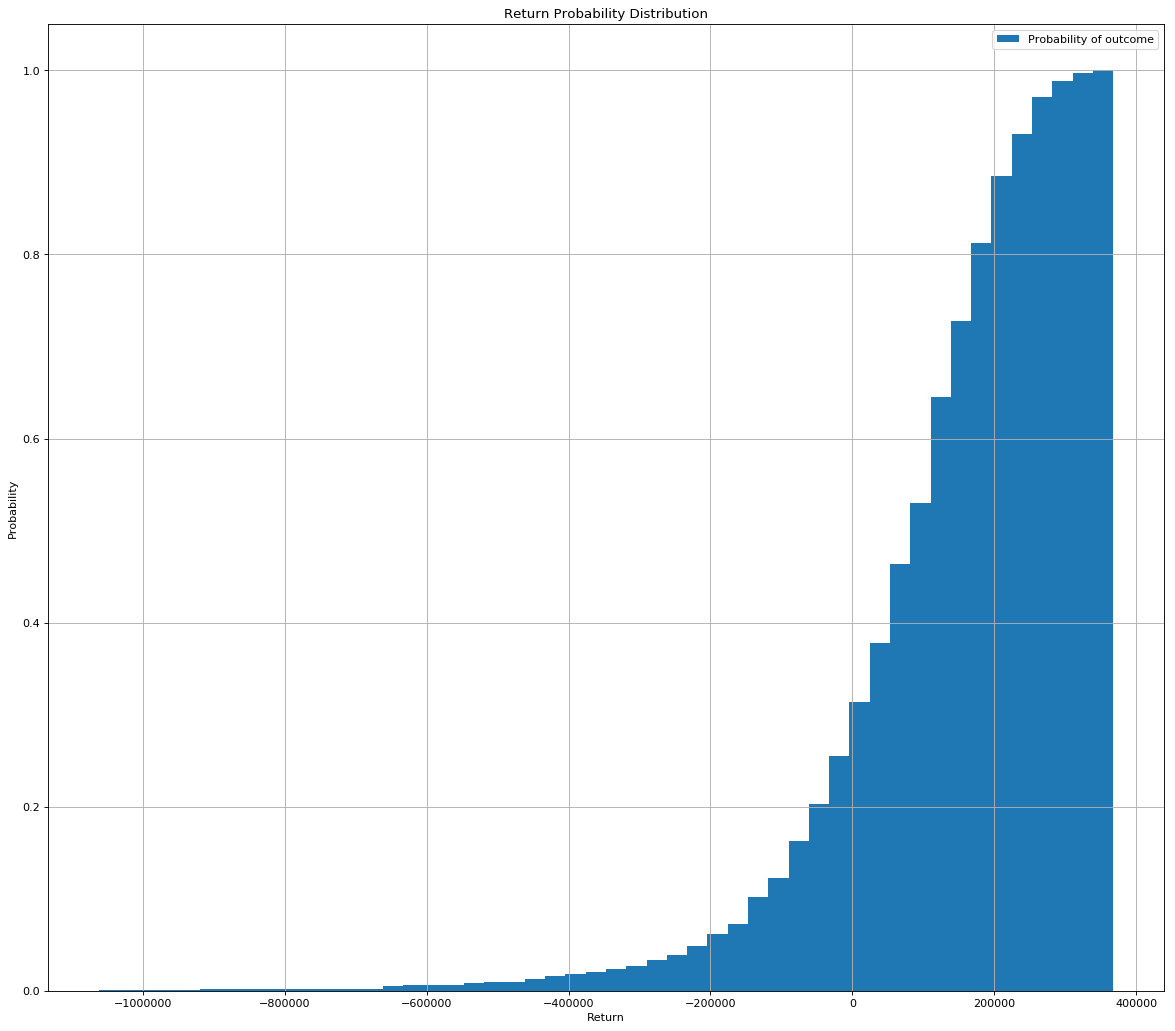

In [22]:
returns = []
year = 10

NUM_ITERATIONS = 1000

for i in range(NUM_ITERATIONS):
    cost_diff, rent_value, home_sale_value, home_value, debt= run_simulation(home_appreciation_std=0.006, market_std=0.045,fixed_property_tax=False)
    returns.append(cost_diff[12*year])
    
# the histogram of the data
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(returns, bins=50, density=True, label='Probability of outcome', cumulative=True)

plt.xlabel('Return')
plt.ylabel('Probability')
plt.legend()
plt.title('Return Probability Distribution')
plt.grid(True)


plt.show()

# Analysis Find Home Price for 90% Confidence in Positive Return After 10 Years

In [57]:
# This block can take a very long time to complete, depending on NUM_ITERATIONS value. 500 is usually sufficient

from scipy import optimize, stats

returns = []
year = 10
percentile = 90

NUM_ITERATIONS = 500

x0 = 500000  # We can pick almost any positive home price here as the cost function is positive, semidefinite

x = []
y = []

def get_returns(price):
    returns = []
    for i in range(NUM_ITERATIONS):
        cost_diff, rent_value, home_sale_value, home_value, debt= run_simulation(home_appreciation_std=0.006, market_std=0.045,fixed_property_tax=True, 
                                                                                 PURCHASE_PRICE=price, MONTHLY_MORTGAGE_PAYMENT = (price*0.8)*(1-1/(1+INTEREST_RATE/12))/(1-1/(1+INTEREST_RATE/12)**(PRINCIPLE_AMORTIZATION*12+1)), DOWNPAYMENT = price*0.2)
        returns.append(cost_diff[12*year])
    return returns

def cost_func(x):
    price = x[0]
    
    returns = get_returns(price)
    percentile_break_even = stats.percentileofscore(returns, 0)
        
    return abs((100-percentile)-percentile_break_even)

  
result = optimize.minimize(cost_func, x0, method="Nelder-Mead", tol=1) 
print("Cost which results in 90% odds of a positive return over 10 years is : " + str(result.x[0]))


# For fun, you can uncomment this code to see how the cost function (the percentile difference between
# the 90th percentile and the actual percentile at the chosen price point) changes over price

# bins = np.linspace(50000,1000000,30)
# for bin in bins:
#     x.append(bin)
#     y.append(cost_func([bin]))
    
# plt.plot(x,y)
# plt.xlabel('Home Price')
# plt.ylabel('Cost Function')
# plt.title('Cost Function being Minimized over Price')
# plt.grid(True)


Cost which results in 90% odds of a positive return over 10 years is : 538281.25
